## Figures - ala4

In [51]:
import numpy as np
from scipy.stats import gaussian_kde

import matplotlib.pyplot as plt
from tqdm.notebook import trange

In [52]:
#set bigger font sizes
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIG_SIZE = 16

plt.rc('font', size=SMALL_SIZE)        # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)   # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIG_SIZE)   # fontsize of the figure title

In [53]:
#set palette
import fessa
plt.set_cmap('fessa')

<Figure size 432x288 with 0 Axes>

In [54]:
import bgmol
import mdtraj as md
import nglview as nv
import openmm
from openmm import unit
kB = unit.MOLAR_GAS_CONSTANT_R.value_in_unit(unit.kilojoule_per_mole/unit.kelvin)

In [56]:
#ala4
system_name = 'AlanineTetrapeptide'
prior_details = 'VacuumModified3'
target_details = 'Implicit'

def get_model(temperature=None, system_name=system_name+prior_details):
    if 'AlanineTetrapeptideImplicit' in system_name:
        model = bgmol.system_by_name('MiniPeptide', aminoacids='AAA')
    elif 'AlanineTetrapeptideVacuum' in system_name:
        model = bgmol.system_by_name('MiniPeptide', aminoacids='AAA', forcefield=["amber99sbildn.xml"])
    else:
        model = bgmol.system_by_name(system_name)
    if 'Modified' in system_name:
        extraBias_str = '100*sin(0.5*theta)^2'
        extraBias = openmm.CustomTorsionForce(extraBias_str)
        if system_name[-1] == '3':
            for i in range(3):
                modified_psi = md.compute_psi(md.Trajectory(model.positions, model.mdtraj_topology))[0][i]   
                extraBias.addTorsion(*modified_psi)
                print(f"{system_name}, adding bias on psi{modified_psi}: {extraBias_str}")
        else:
            modified_psi = md.compute_psi(md.Trajectory(model.positions, model.mdtraj_topology))[0][-1]   
            extraBias.addTorsion(*modified_psi)
            print(f"{system_name}, adding bias on psi{modified_psi}: {extraBias_str}")
        model.system.addForce(extraBias)
    if temperature is not None:
        model.reinitialize_energy_model(temperature=temperature)#, n_workers=1)
    return model

model = get_model()

view = nv.show_mdtraj(md.Trajectory(model.positions, model.mdtraj_topology))
view.clear_representations()
view.add_licorice()
view

Using downloaded and verified file: /tmp/AAA.pdb
AlanineTetrapeptideVacuumModified3, adding bias on psi[ 6  8 14 16]: 100*sin(0.5*theta)^2
AlanineTetrapeptideVacuumModified3, adding bias on psi[16 18 24 26]: 100*sin(0.5*theta)^2
AlanineTetrapeptideVacuumModified3, adding bias on psi[26 28 34 36]: 100*sin(0.5*theta)^2


NGLWidget()

In [58]:
# view.download_image(filename='ala4.png', trim=True, transparent=True)

## Load data and calculate FES

In [59]:
from calcFES import calcFES

highT = 1000
lowT = 300

bw = 0.2
grid = np.linspace(-np.pi, np.pi, 75)
grid2D = np.meshgrid(grid, grid)

def get_phi_psi(trajectory, i=-1, model=model):
    if not isinstance(trajectory, md.Trajectory):
        # if isinstance(trajectory, torch.Tensor):
        #     trajectory = assert_numpy(trajectory.view(len(trajectory), *model.positions.shape))
        trajectory = md.Trajectory(trajectory, model.mdtraj_topology)
    phi = md.compute_phi(trajectory)[1][:,i]
    psi = md.compute_psi(trajectory)[1][:,i]
    return phi, psi

In [60]:
%%time

# prior_data = np.concatenate([np.load(f'traj-{system_name+prior_details}-T{highT}-{i}.npy') for i in range(2)])
prior_data = np.load(f'{system_name+prior_details}To{target_details}-traj.npz')['highT']
prior_fes = []
for i in trange(3):
    prior_fes.append(calcFES(grid2D, (bw,bw), get_phi_psi(prior_data, i=i), periodic=True))

  0%|          | 0/3 [00:00<?, ?it/s]

CPU times: user 43.1 s, sys: 0 ns, total: 43.1 s
Wall time: 43.4 s


In [143]:
%%time
import plumed

colvar = plumed.read_as_pandas(f'COLVAR-{system_name+target_details}_T{lowT}')
skip = 0
opes_fes = []
for i in trange(3):
    opes_fes.append(calcFES(grid2D, (bw,bw), (colvar[f'phi{1+i}'][skip:],colvar[f'psi{1+i}'][skip:]), logweights=colvar['opes.bias'][skip:]/(kB*lowT), periodic=True))

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/mi/minvernizzi/miniconda3/envs/bgflow/lib/libplumedKernel.so" +++


  0%|          | 0/3 [00:00<?, ?it/s]

CPU times: user 1min 25s, sys: 0 ns, total: 1min 25s
Wall time: 1min 25s


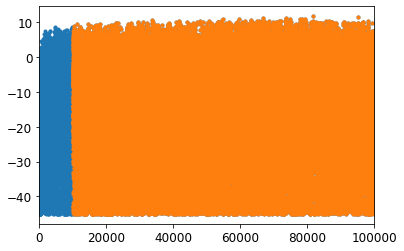

100000


In [144]:
plt.plot(colvar['opes.bias'], '.')
plt.plot(colvar['opes.bias'][10_000:], '.')
plt.xlim(0,len(colvar['opes.bias']))
plt.show()
print(len(colvar['opes.bias']))

In [110]:
%%time

opesMT_data = np.load(f'MD-{system_name+target_details}-multiT{lowT}.npz')['traj']
logw = np.load(f'MD-{system_name+target_details}-multiT{lowT}.npz')['bias']/(kB*lowT)
opesMT_fes = []
for i in trange(3):
    opesMT_fes.append(calcFES(grid2D, (bw,bw), get_phi_psi(opesMT_data, i=i), logweights=logw, periodic=True))

  0%|          | 0/3 [00:00<?, ?it/s]

CPU times: user 3min 45s, sys: 0 ns, total: 3min 45s
Wall time: 3min 44s


In [62]:
%%time

target_data = np.load(f'{system_name+prior_details}To{target_details}-traj.npz')['lowT']
target_fes = []
for i in trange(3):
    target_fes.append(calcFES(grid2D, (bw,bw), get_phi_psi(target_data, i=i), periodic=True))

  0%|          | 0/3 [00:00<?, ?it/s]

CPU times: user 43 s, sys: 0 ns, total: 43 s
Wall time: 43.3 s


In [63]:
%%time
mapped_data = np.load(f'{system_name+prior_details}To{target_details}-trajMapped.npz')['data']
logw = np.load(f'{system_name+prior_details}To{target_details}-trajMapped.npz')['logw']

mapped_fes = []
for i in trange(3):
    mapped_fes.append(calcFES(grid2D, (bw,bw), get_phi_psi(mapped_data, i=i), logweights=logw, periodic=True))

  0%|          | 0/3 [00:00<?, ?it/s]

CPU times: user 42.3 s, sys: 0 ns, total: 42.3 s
Wall time: 42.6 s


In [98]:
view = nv.show_mdtraj(md.Trajectory(target_data[37600], model.mdtraj_topology))
view.clear_representations()
view.add_licorice()
view

NGLWidget()

In [99]:
view.download_image(filename='ala4.png', trim=True, transparent=True)

## create plot

In [65]:
#plot function

ticks = [-np.pi/2, 0, np.pi/2], ['$-\pi/2$','0','$\pi/2$']
def plot_2D_fes(ax, fes, vmax=10, title=None):
    imshow_opt = {'vmax': vmax, 'origin': 'lower', 'extent': (-np.pi,np.pi,-np.pi,np.pi), 'rasterized': True}
    if title is not None:
        ax.set_title(title)
    # alpha = np.where(fes>vmax, 0., 1.)
    # cb = ax.imshow(fes, alpha=alpha, **imshow_opt)
    cb = ax.imshow(fes, **imshow_opt)
    ax.set_aspect('equal')
    ax.set_yticks(*ticks)
    ax.set_xticks(*ticks)
    # ax.set_ylabel('$\psi$')
    # ax.set_xlabel('$\phi$')
    return cb

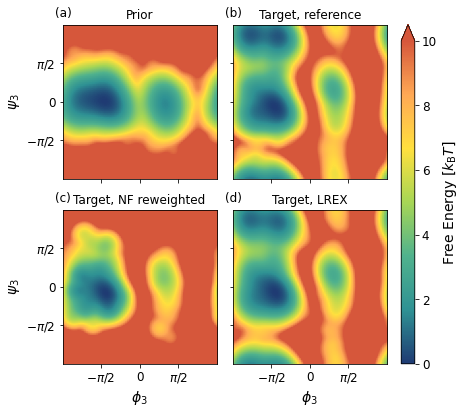

In [145]:
i = 2
vmax = 10

fig = plt.figure(figsize=(6.4, 1.3*4.8))
gs = fig.add_gridspec(2, 2, wspace=0.1, hspace=0.2)
axs = gs.subplots(sharex=True, sharey=True)
tag_pos = (-0.05, 1.05)

ax = axs[0,0]
ax.text(*tag_pos, '(a)', transform=ax.transAxes, fontdict={'size': 12})
ax.set_title('Prior')
plot_2D_fes(ax, prior_fes[i], vmax=vmax)
ax.set_ylabel(f'$\psi_{1+i}$')
# ax.set_xlabel(None)

ax = axs[0,1]
ax.text(*tag_pos, '(b)', transform=ax.transAxes, fontdict={'size': 12})
ax.set_title('Target, reference')
plot_2D_fes(ax, opes_fes[i], vmax=vmax)
# plot_2D_fes(ax, opesMT_fes[i], vmax=vmax)
# ax.set_ylabel(None)

ax = axs[1,0]
ax.text(*tag_pos, '(c)', transform=ax.transAxes, fontdict={'size': 12})
ax.set_title('Target, NF reweighted')
plot_2D_fes(ax, mapped_fes[i], vmax=vmax)
ax.set_xlabel(f'$\phi_{1+i}$')
ax.set_ylabel(f'$\psi_{1+i}$')

ax = axs[1,1]
ax.text(*tag_pos, '(d)', transform=ax.transAxes, fontdict={'size': 12})
ax.set_title('Target, LREX')
cb = plot_2D_fes(ax, target_fes[i], vmax=vmax)
ax.set_xlabel(f'$\phi_{1+i}$')
plt.colorbar(cb, ax=axs, label='Free Energy [$k_\mathrm{B}T$]', extend='max', pad=0.04, fraction=0.05, aspect=25)

plt.savefig(f'Ala4-all.pdf', bbox_inches='tight')
plt.show()

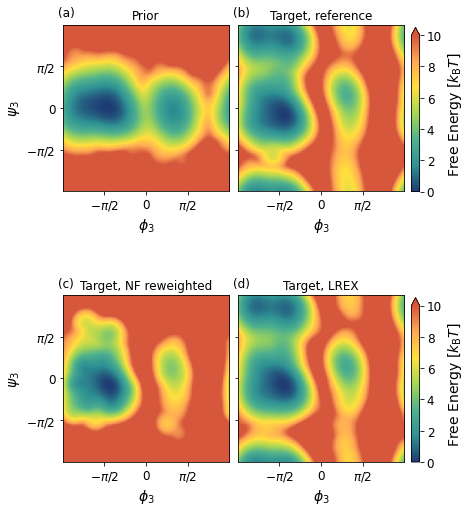

In [96]:
# i = 2
# vmax = 10

# fig = plt.figure(figsize=(6.4, 1.9*4.8))
# gs = fig.add_gridspec(2, 2, wspace=0.05)#, hspace=0.2)
# axs = gs.subplots(sharey=True)
# tag_pos = (-0.03, 1.05)
# colorbar_opt = {'label': 'Free Energy [$k_\mathrm{B}T$]', 'extend': 'max', 'pad': 0.02, 'fraction': 0.023}

# ax = axs[0,0]
# ax.text(*tag_pos, '(a)', transform=ax.transAxes)
# ax.set_title('Prior')
# plot_2D_fes(ax, prior_fes[i], vmax=vmax)
# ax.set_xlabel(f'$\phi_{1+i}$')
# ax.set_ylabel(f'$\psi_{1+i}$')

# ax = axs[0,1]
# ax.text(*tag_pos, '(b)', transform=ax.transAxes)
# ax.set_title('Target, reference')
# cb = plot_2D_fes(ax, opes_fes[i], vmax=vmax)
# ax.set_xlabel(f'$\phi_{1+i}$')
# plt.colorbar(cb, ax=axs[0], **colorbar_opt)

# ax = axs[1,0]
# ax.text(*tag_pos, '(c)', transform=ax.transAxes)
# ax.set_title('Target, NF reweighted')
# plot_2D_fes(ax, mapped_fes[i], vmax=vmax)
# ax.set_xlabel(f'$\phi_{1+i}$')
# ax.set_ylabel(f'$\psi_{1+i}$')

# ax = axs[1,1]
# ax.text(*tag_pos, '(d)', transform=ax.transAxes)
# ax.set_title('Target, LREX')
# cb = plot_2D_fes(ax, target_fes[i], vmax=vmax)
# ax.set_xlabel(f'$\phi_{1+i}$')
# plt.colorbar(cb, ax=axs[1], **colorbar_opt)

# # arrow_opt = {'length_includes_head': True, 'width': 0.001, 'head_width': 0.07, 'color': 'k', 'ls': ':'}
# # ax.arrow()

# plt.savefig(f'Ala4-all.pdf', bbox_inches='tight')
# plt.show()

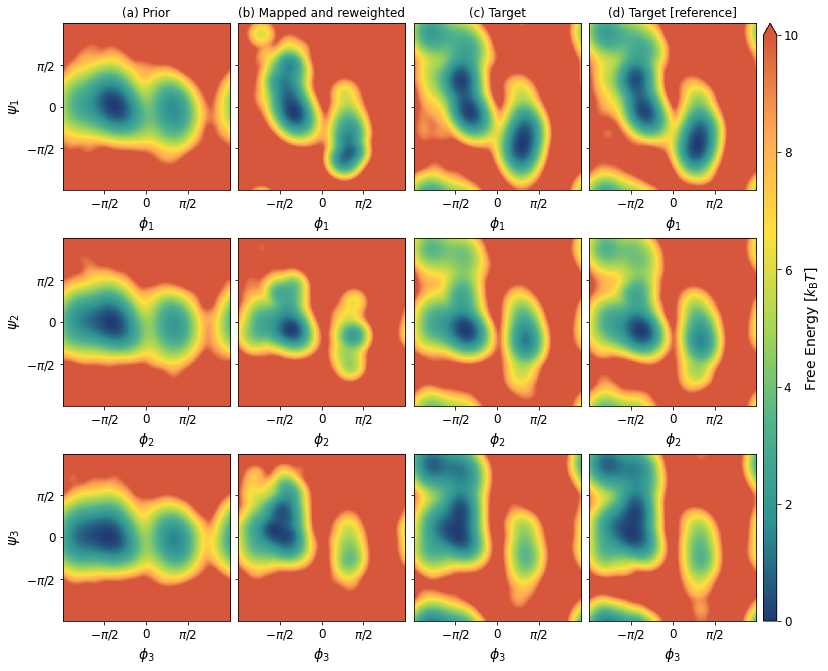

In [35]:
vmax = 10
fig = plt.figure(figsize=(6.4*2, 4.8*2.4))
gs = fig.add_gridspec(3, 4, wspace=0.05, hspace=0.1)
axs = gs.subplots(sharex=False, sharey=False)
axs[0,0].set_title('(a) Prior')
axs[0,1].set_title('(b) Mapped and reweighted')
axs[0,2].set_title('(c) Target')
axs[0,3].set_title('(d) Target [reference]')
for i in range(3):
    plot_2D_fes(axs[i,0], prior_fes[i], vmax)
    plot_2D_fes(axs[i,1], mapped_fes[i], vmax)
    plot_2D_fes(axs[i,2], target_fes[i], vmax)
    cb = plot_2D_fes(axs[i,3], opes_fes[i], vmax)
    for j in range(4):
        axs[i,j].set_xlabel(f'$\phi_{1+i}$')
    axs[i,0].set_ylabel(f'$\psi_{1+i}$')
    axs[i,1].set_yticks([-np.pi/2, 0, np.pi/2], ['','',''])
    axs[i,2].set_yticks([-np.pi/2, 0, np.pi/2], ['','',''])
    axs[i,3].set_yticks([-np.pi/2, 0, np.pi/2], ['','',''])
plt.colorbar(cb, ax=axs, label='Free Energy [$k_\mathrm{B}T$]', extend='max', extendfrac=0.02, pad=0.01, fraction=0.0186, aspect=45)
plt.savefig(f'Ala4-FES_phipsi.pdf', bbox_inches='tight')
plt.show()

In [36]:
100_000*np.exp(-10)

4.539992976248485

## Ramachandran histogram

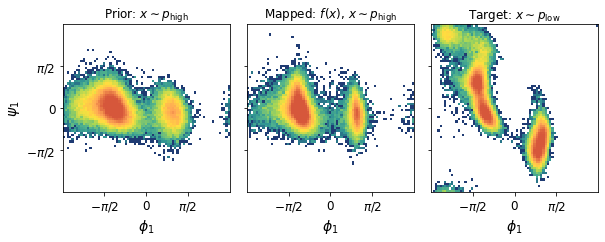

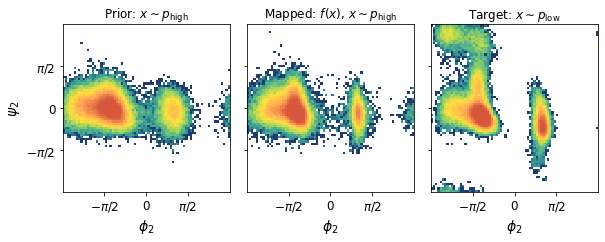

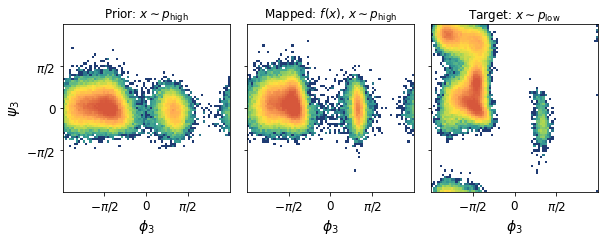

In [37]:
save = True

from matplotlib.colors import LogNorm
plot_range = (-np.pi, np.pi)
ticks = [-np.pi/2, 0, np.pi/2], ['$-\pi/2$','0','$\pi/2$']
def plot_rama(ax, phi, psi, label=None, bins=75, vmax=4e2):
    ax.set_title(label)
    ct = ax.hist2d(phi, psi, bins, range=[plot_range,plot_range], norm=LogNorm(vmax=vmax), rasterized=True)
    ax.set_xlim(plot_range)
    ax.set_ylim(plot_range)
    # ax.set_xlabel("$\phi$")
    # ax.set_ylabel("$\psi$")
    ax.set_yticks(*ticks)
    ax.set_xticks(*ticks)
    ax.set_box_aspect(1)
    # ax.colorbar()
    return ct[-1]
    
for i in range(3):
    fig = plt.figure(figsize=(1.5*6.4, 4.8))
    gs = fig.add_gridspec(1, 3, wspace=0.1)
    axs = gs.subplots(sharex=True, sharey=True)
    plot_rama(axs[0], *get_phi_psi(prior_data, i=i), 'Prior: $x \sim p_{\mathrm{high}}$')
    axs[0].set_ylabel(f'$\psi_{1+i}$')
    axs[0].set_xlabel(f'$\phi_{1+i}$')
    plot_rama(axs[1], *get_phi_psi(mapped_data, i=i), 'Mapped: $f(x)$, $x \sim p_{\mathrm{high}}$')
    axs[1].set_xlabel(f'$\phi_{1+i}$')
    plot_rama(axs[2], *get_phi_psi(target_data, i=i), 'Target: $x \sim p_{\mathrm{low}}$')
    axs[2].set_xlabel(f'$\phi_{1+i}$')
    if save:
        plt.savefig(f'Ala4-hist_phipsi-{1+i}.pdf', bbox_inches='tight')
    plt.show()

In [38]:
# some plotting functions
from matplotlib.colors import LogNorm

plot_range = (-np.pi, np.pi)
ticks = [-np.pi/2, 0, np.pi/2], ['$-\pi/2$','0','$\pi/2$']
def plot_rama(ax, phi, psi, label=None, w=None, bins=75, vmax=8):
    if label is not None:
        ax.set_title(label)
    grid = np.linspace(*plot_range, bins)
    hist, *_ = np.histogram2d(phi, psi, bins=(grid, grid), weights=w)
    fes = -np.log(np.where(hist!=0, hist / hist.max(), np.nan)).T
    ct = ax.pcolormesh(*np.meshgrid(grid, grid), fes, vmax=vmax, rasterized=True)
    ax.set_xlim(plot_range)
    ax.set_ylim(plot_range)
    # ax.set_xlabel("$\phi$")
    ax.set_yticks(*ticks)
    ax.set_xticks(*ticks)
    ax.set_box_aspect(1)
    return ct

def get_phi_psi(trajectory, i=-1, model=model):
        if not isinstance(trajectory, md.Trajectory):
            # if isinstance(trajectory, torch.Tensor):
            #     trajectory = assert_numpy(trajectory.view(len(trajectory), *model.positions.shape))
            trajectory = md.Trajectory(trajectory, model.mdtraj_topology)
        phi = md.compute_phi(trajectory)[1][:,i]
        psi = md.compute_psi(trajectory)[1][:,i]
        return phi, psi

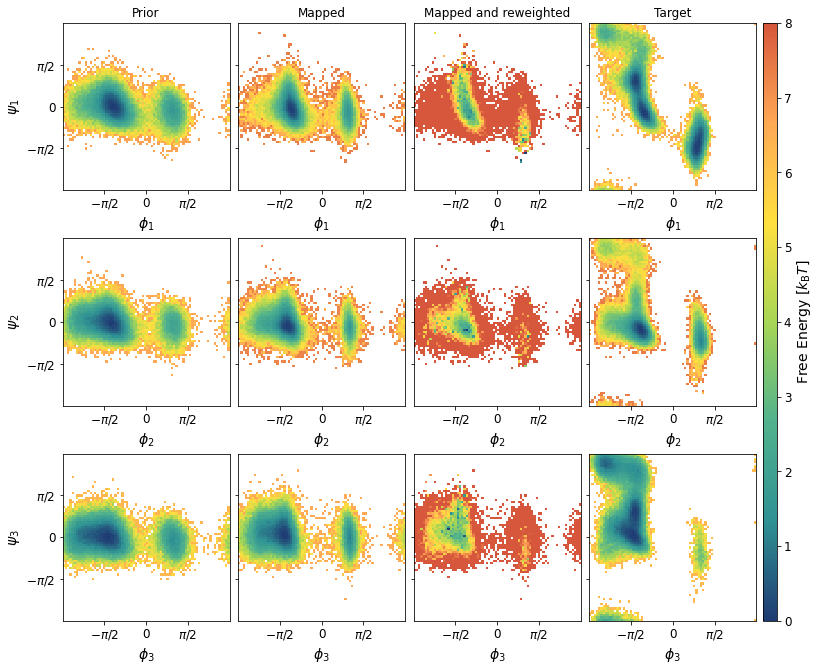

In [39]:

fig = plt.figure(figsize=(6.4*2, 4.8*2.4))
gs = fig.add_gridspec(3, 4, wspace=0.05, hspace=0.1)
axs = gs.subplots(sharex=False, sharey=False)
axs[0,0].set_title('Prior')
axs[0,1].set_title('Mapped')
axs[0,2].set_title('Mapped and reweighted')
axs[0,3].set_title('Target')
for i in range(3):
    plot_rama(axs[i,0], *get_phi_psi(prior_data, i=i))
    plot_rama(axs[i,1], *get_phi_psi(mapped_data, i=i))
    plot_rama(axs[i,2], *get_phi_psi(mapped_data, i=i), w=np.exp(logw))
    cb = plot_rama(axs[i,3], *get_phi_psi(target_data, i=i))
    for j in range(4):
        axs[i,j].set_xlabel(f'$\phi_{1+i}$')
    axs[i,0].set_ylabel(f'$\psi_{1+i}$')
    axs[i,1].set_yticks([-np.pi/2, 0, np.pi/2], ['','',''])
    axs[i,2].set_yticks([-np.pi/2, 0, np.pi/2], ['','',''])
    axs[i,3].set_yticks([-np.pi/2, 0, np.pi/2], ['','',''])
plt.colorbar(cb, ax=axs, label='Free Energy [$k_\mathrm{B}T$]', pad=0.01, fraction=0.0186, aspect=45)
if save:
    plt.savefig(f'Ala4-hist_phipsi-{1+i}.pdf', bbox_inches='tight')
plt.show()

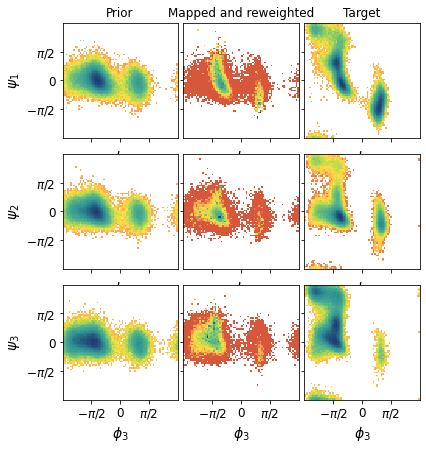

In [40]:
fig = plt.figure(figsize=(6.4, 4.8*1.5))
gs = fig.add_gridspec(3, 3, wspace=0.05, hspace=0.01)
axs = gs.subplots(sharex=False, sharey=False)
axs[0,0].set_title('Prior')
axs[0,1].set_title('Mapped and reweighted')
axs[0,2].set_title('Target')
for i in range(3):
    plot_rama(axs[i,0], *get_phi_psi(prior_data, i=i))
    plot_rama(axs[i,1], *get_phi_psi(mapped_data, i=i), w=np.exp(logw-logw.max()))
    plot_rama(axs[i,2], *get_phi_psi(target_data, i=i))
    for j in range(3):
        axs[i,j].set_xlabel(f'$\phi_{1+i}$')
        axs[i,j].set_xticks([-np.pi/2, 0, np.pi/2], ['','',''])
    axs[i,0].set_ylabel(f'$\psi_{1+i}$')
    axs[i,1].set_yticks([-np.pi/2, 0, np.pi/2], ['','',''])
    axs[i,2].set_yticks([-np.pi/2, 0, np.pi/2], ['','',''])
for j in range(3):
    axs[2,j].set_xticks([-np.pi/2, 0, np.pi/2], ['$-\pi/2$','0','$\pi/2$'])
if save:
    plt.savefig(f'Ala4-FES_phipsi-{1+i}.pdf', bbox_inches='tight')
plt.show()

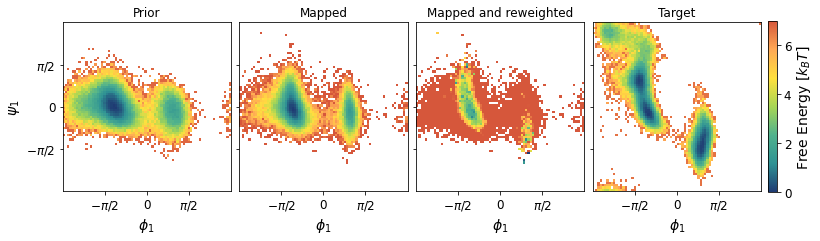

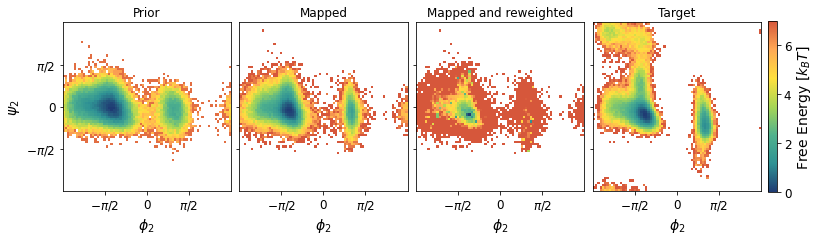

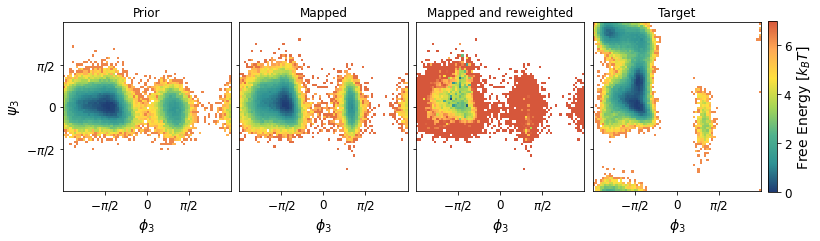

In [41]:
save = False
vmax = 7
bins = 75

for i in range(3):
    fig = plt.figure(figsize=(6.4*2, 4.8))
    gs = fig.add_gridspec(1, 4, wspace=0.05)
    axs = gs.subplots()#sharex=True, sharey=True)

    ax = axs[0]
    ax.set_title('Prior')
    plot_rama(ax, *get_phi_psi(prior_data, i=i), vmax=vmax, bins=bins)
    ax.set_xlabel(f'$\phi_{1+i}$')
    ax.set_ylabel(f'$\psi_{1+i}$')

    ax = axs[1]
    ax.set_title('Mapped')
    plot_rama(ax, *get_phi_psi(mapped_data, i=i), vmax=vmax, bins=bins)
    ax.set_xlabel(f'$\phi_{1+i}$')
    ax.set_yticks([-np.pi/2, 0, np.pi/2], ['','',''])

    ax = axs[2]
    ax.set_title('Mapped and reweighted')
    plot_rama(ax, *get_phi_psi(mapped_data, i=i), w=np.exp(logw-logw.max()), vmax=vmax, bins=bins)
    ax.set_xlabel(f'$\phi_{1+i}$')
    ax.set_yticks([-np.pi/2, 0, np.pi/2], ['','',''])

    ax = axs[3]
    ax.set_title('Target')
    ct = plot_rama(ax, *get_phi_psi(target_data, i=i), vmax=vmax, bins=bins)
    ax.set_xlabel(f'$\phi_{1+i}$')
    ax.set_yticks([-np.pi/2, 0, np.pi/2], ['','',''])

    cb = plt.colorbar(ct, ax=axs, ticks=np.arange(0,12,2), pad=0.01, fraction=0.012)
    cb.set_label('Free Energy [$k_BT$]')
    if save:
        plt.savefig(f'Ala4-FES_phipsi-{1+i}.pdf', bbox_inches='tight')
    plt.show()

## phi FES

In [23]:
save = False
from calcFES import calcFES

# size = len(target_data)
# block = slice(0, size)
# block2 = slice(0, size//2)

bw = 0.15
grid = np.linspace(-np.pi, np.pi, 100)

for i in range(3):
    fig = plt.figure(figsize=(6.4, 4.8))
    
    # prior_fes_phi = calcFES(grid, bw, get_phi_psi(prior_data, i=i)[0], periodic=True)
    # plt.plot(grid, prior_fes_phi, c='fessa6', lw=2.5, label='Prior, $T_{\mathrm{high}}$ vacuum')
    
    # target_fes_phi = calcFES(grid, bw, colvar[f'psi{1+i}'], opes_logw, periodic=True)
    target_fes_phi = calcFES(grid, bw, get_phi_psi(opes_data, i=i)[1], opes_logw, periodic=True)
    plt.plot(grid, target_fes_phi, c='fessa0', lw=2.5, label='Target, $T_{\mathrm{low}}$ implicit solvent')
    
    # mapped_fes_phi = calcFES(grid, bw, get_phi_psi(mapped_data, i=i)[0], periodic=True)
    # plt.plot(grid, mapped_fes_phi, c='fessa2', lw=2.5, ls=':', label='Mapped prior')
    
    lrex_fes_phi = calcFES(grid, bw, get_phi_psi(target_data, i=i)[1], periodic=True)
    plt.plot(grid, lrex_fes_phi, c='fessa4', lw=2.5, ls='-.', label='LREX replica')
    
    reweight_fes_phi = calcFES(grid, bw, get_phi_psi(mapped_data, i=i)[1], logw, periodic=True)
    plt.plot(grid, reweight_fes_phi, c='fessa2', lw=2.5, ls='--', label='Mapped and reweighted')
    
    plt.xlim(plot_range)
    plt.xticks(*ticks)
    plt.xlabel(f'$\phi_{1+i}$')
    plt.ylim(0, 10)
    plt.ylabel('Free Energy [$k_BT$]')
    plt.legend(loc='upper left')
    if save:
        plt.savefig(f'Ala4-FES_phi-{1+i}.pdf', bbox_inches='tight')
    plt.show()

NameError: name 'opes_data' is not defined

<Figure size 460.8x345.6 with 0 Axes>

In [ ]:
plt.hist(np.exp(logw), bins=75)
plt.yscale('log')
plt.show()

ess = np.exp(2*np.logaddexp.reduce(logw)-np.logaddexp.reduce(2*logw))
print(f'ESS: {ess:g}')
print(f'sampling efficiency: {ess/len(logw):.2%}')

In [ ]:
n_cut = 20_000
sorted_index = np.argsort(logw)
sorted_logw = logw[sorted_index][:-n_cut]
sorted_mapped_data = mapped_data[sorted_index][:-n_cut]
ess = np.exp(2*np.logaddexp.reduce(sorted_logw)-np.logaddexp.reduce(2*sorted_logw))
print(f'ESS: {ess:g}')
print(f'sampling efficiency: {ess/len(logw):.2%}')
plt.hist(np.exp(sorted_logw), bins=75)
plt.yscale('log')
plt.show()

# # mapped_phi = mapped_phi[sorted_index]
# logw = logw[:-10]
# # mapped_phi = mapped_phi[:-10]

In [ ]:
sorted_index = np.argsort(logw)
sorted_logw = logw[sorted_index]

def ess(logw):
    return np.exp(2*np.logaddexp.reduce(logw)-np.logaddexp.reduce(2*logw))

n_cut = np.arange(0, len(sorted_logw)//2, 100)
new_ess = [ess(sorted_logw[:-x]) for x in n_cut]

plt.plot(n_cut, new_ess)
plt.show()

In [ ]:
plt.plot(n_cut, new_ess)
plt.show()

## Energies

In [42]:
%%time
import torch
ctx = {"device": torch.device('cpu'), "dtype": torch.float32}

#all energies in the target hamiltonian
target_model = get_model(system_name=system_name+target_details, temperature=lowT)
print('prior ener')
data = np.load(f'{system_name+prior_details}To{target_details}-traj.npz')['highT']
# prior_model = get_model(system_name=system_name+prior_details, temperature=highT)
with torch.no_grad():
    prior_ener = target_model.energy(torch.as_tensor(data, **ctx).view(len(data),-1)).view(-1).cpu().numpy() * (kB*lowT)
print('target ener')
data = np.load(f'{system_name+prior_details}To{target_details}-traj.npz')['lowT']
# target_model = get_model(system_name=system_name+target_details, temperature=lowT)
with torch.no_grad():
    target_ener = target_model.energy(torch.as_tensor(data, **ctx).view(len(data),-1)).view(-1).cpu().numpy() * (kB*lowT)
print('mapped ener')
data = np.load(f'{system_name+prior_details}To{target_details}-trajMapped.npz')['data']
with torch.no_grad():
    mapped_ener = target_model.energy(torch.as_tensor(data, **ctx).view(len(data),-1)).view(-1).cpu().numpy() * (kB*lowT)

Using downloaded and verified file: /tmp/AAA.pdb


/srv/data/minvernizzi/programs/bgflow/bgflow/distribution/energy/openmm.py:200: UserWarning: It looks like you are using an OpenMMBridge with multiple workers in an ipython environment. This can behave a bit silly upon KeyboardInterrupt (e.g., kill the stdout stream). If you experience any issues, consider initializing the bridge with n_workers=1 in ipython/jupyter.
  warnings.warn(


prior ener
target ener
mapped ener
CPU times: user 24.3 s, sys: 11.8 s, total: 36.1 s
Wall time: 41 s


In [43]:
prior_model = get_model(system_name=system_name+prior_details, temperature=highT)
with torch.no_grad():
    orig_prior_ene = prior_model.energy(torch.as_tensor(data, **ctx).view(len(data),-1)).view(-1).cpu().numpy() * (kB*highT)

Using downloaded and verified file: /tmp/AAA.pdb
AlanineTetrapeptideVacuumModified3, adding bias on psi[ 6  8 14 16]: 100*sin(0.5*theta)^2
AlanineTetrapeptideVacuumModified3, adding bias on psi[16 18 24 26]: 100*sin(0.5*theta)^2
AlanineTetrapeptideVacuumModified3, adding bias on psi[26 28 34 36]: 100*sin(0.5*theta)^2


In [44]:
target_ener.min(), prior_ener.max()

(9.23503, 645.31335)

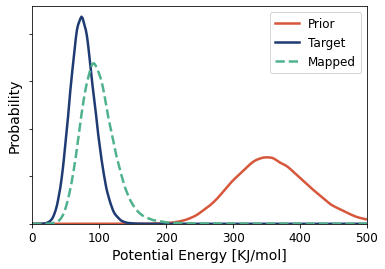

In [49]:
save_to_file = False

highT = 1000
lowT = 300
# xlim = [-100, 250]
grid = np.linspace(0, 500, 300)
# grid = np.linspace(-100, 500, 300)
# grid = np.linspace(-30, 250, 300)

# prior_ene = np.load(f'ene-{system_name}-T{highT}.npy').reshape(-1) * (kB*highT)
# target_ene = np.load(f'ene-{system_name}-T{lowT}.npy').reshape(-1) * (kB*lowT)
# mapped_ene = rama_data['mapped_ene'][training_len:] * (kB*lowT)

ene = prior_ener
# grid = np.linspace(ene.min(), ene.max(), 100)
plt.plot(grid, gaussian_kde(ene).pdf(grid), color=f'fessa6', label='Prior', lw=2.5)
ene = target_ener
# grid = np.linspace(ene.min(), ene.max(), 100)
plt.plot(grid, gaussian_kde(ene).pdf(grid), color=f'fessa0', label='Target', lw=2.5)
ene = mapped_ener[mapped_ener<grid[-1]]
# grid = np.linspace(ene.min(), ene.max(), 100)
# grid = np.linspace(ene.min(), xlim[-1], 100)
plt.plot(grid, gaussian_kde(ene).pdf(grid), color=f'fessa2', label='Mapped', lw=2.5, ls='--')

# plt.xlim(xlim)
plt.xlim(grid[0], grid[-1])
plt.ylim(0, None)
plt.xlabel('Potential Energy [KJ/mol]')
plt.ylabel('Probability')
plt.gca().set_yticklabels([])
plt.legend()
if save_to_file:
    plt.savefig('MappedEnergies.png', dpi=1000)
    # plt.savefig('MappedEnergies.svg', dpi=300)
plt.show()

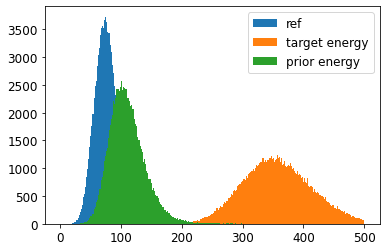

In [50]:
plt.hist(target_ener, bins=grid, label='ref')
plt.hist(prior_ener, bins=grid, label='target energy')
plt.hist(orig_prior_ene, bins=grid, label='prior energy')
plt.legend()
plt.show()

In [47]:
orig_prior_ene.max()

2590267000.0